# Large N implies overconfidence? Do we need to re-scale the Likelihood?

In [1]:
from collections import OrderedDict

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from scipy import stats
from scipy.stats import invgamma, norm

In [4]:
import corner

In [5]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [6]:
import pickle
from pathlib import Path

import numpy as np
import rose
from matplotlib import colormaps as cm
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
from rose.training import multiple_formatter
from tqdm import tqdm

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

plt.rc("font", **{"family": "serif", "serif": ["tgpagella"]})
rcParams["text.latex.preamble"] = (
    r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
)
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

In [7]:
true_params = OrderedDict(
    [
        ("m", 2),
        ("b", 4),
    ]
)

In [8]:
rng = np.random.default_rng(42)

In [9]:
noise = 0.05
N = 200
# x_data = np.sort(np.random.rand(N))
x_data = np.linspace(0, 1, N)
y_true = true_params["m"] * x_data + true_params["b"]
y_err = np.array([rng.normal(0, noise * y) for y in y_true])
y_data = y_true + y_err

reported_stat_err = noise * y_data

In [10]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [11]:
prior_mean = OrderedDict(
    [
        ("m", 0),
        ("b", 4),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.1),
        ("b", 0.5),
    ]
)

In [12]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)
mean

array([0, 4])

In [13]:
my_model = LinearModel()

In [14]:
observation = rxmc.observation.Observation(
    x=x_data,
    y=y_data,
    y_stat_err=y_true * noise,
)

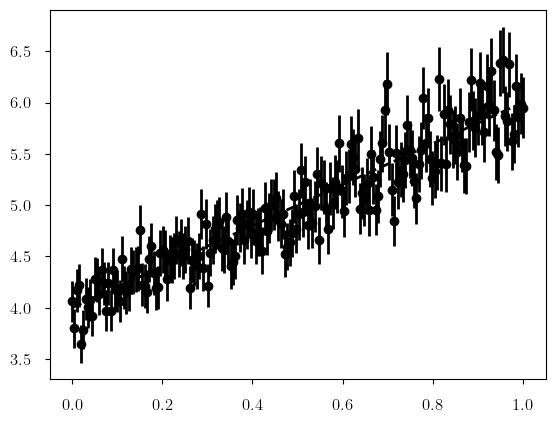

In [15]:
plt.errorbar(
    x_data,
    y_data,
    noise * y_data,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.plot(x_data, y_true, "k--", label="truth")

In [16]:
likelihood = rxmc.likelihood_model.LikelihoodModel()

In [17]:
evidence = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood,
        )
    ],
)

In [18]:
evidence_scaled = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood,
        )
    ],
    weights=np.array([(2 / N)]),
)

In [19]:
def proposal_distribution(x, rng):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 100, random_state=rng
    )

In [20]:
walker_scaled = rxmc.walker.Walker(
    rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        prior=prior_distribution,
        initial_proposal_cov=prior_distribution.cov / 100,
    ),
    evidence_scaled,
)

In [21]:
walker = rxmc.walker.Walker(
    rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
        params=my_model.params,
        starting_location=prior_distribution.mean,
        prior=prior_distribution,
        initial_proposal_cov=prior_distribution.cov / 100,
    ),
    evidence,
)

In [22]:
%%time
walker_scaled.walk(n_steps=10000, burnin=1000, batch_size=500)

Burn-in batch 1/2 completed, 500 steps.
Burn-in batch 2/2 completed, 500 steps.
Batch: 1/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.362
Batch: 2/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.336
Batch: 3/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.340
Batch: 4/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.364
Batch: 5/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.360
Batch: 6/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.344
Batch: 7/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.432
Batch: 8/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.386
Batch: 9/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.324
Batch: 10/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.358
Batch: 11/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.368
Batch: 12/20 completed, 500 steps. 
  

In [23]:
%%time
walker.walk(n_steps=10000, burnin=1000, batch_size=500)

Burn-in batch 1/2 completed, 500 steps.
Burn-in batch 2/2 completed, 500 steps.
Batch: 1/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.186
Batch: 2/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.372
Batch: 3/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.332
Batch: 4/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.388
Batch: 5/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.374
Batch: 6/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.462
Batch: 7/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.370
Batch: 8/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.330
Batch: 9/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.356
Batch: 10/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.416
Batch: 11/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.336
Batch: 12/20 completed, 500 steps. 
  

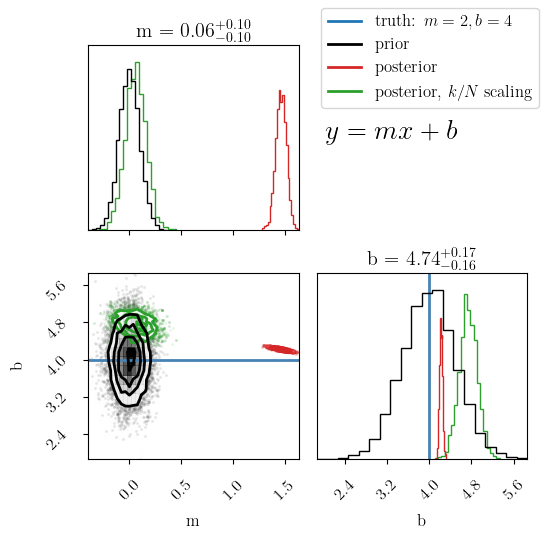

In [41]:
fig = corner.corner(
    walker_scaled.model_sampler.chain,
    color="tab:green",
    truths=[true_params["m"], true_params["b"]],
    labels=["m", "b"],
    show_titles=True,
)

_ = corner.corner(
    walker.model_sampler.chain,
    color="tab:red",
    fig=fig,
)
_ = corner.corner(
    prior_distribution.rvs(10000),
    fig=fig,
)
plt.plot([], [], color="tab:blue", label="truth: $m=2, b=4$")  
plt.plot([], [], color="k", label="prior")

plt.plot([], [], color="tab:red", label="posterior")  
plt.plot([], [], color="tab:green", label="posterior, $k/N$ scaling") 
fig.text(0.6,0.75,"$y=mx+b$", fontsize=20)
fig.legend(loc="upper right")
plt.tight_layout()
plt.savefig("corner_oc_badprior.pdf")

In [42]:
def predictive_posterior(
    walker, model, x, x_data, y_exp, y_err, percentile_bounds, added_noise=0.0
):
    n_posterior_samples = walker.model_sampler.chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker.model_sampler.chain[i, :]
        y[i, :] = np.random.normal(loc=model.y(x, *sample), scale=added_noise)

    percentiles = np.percentile(y, percentile_bounds, axis=0)
    return percentiles

## Empirical coverage

In [43]:
spacing = 10
inner_pctls = np.arange(spacing, 100, spacing)
inner_pctls

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [44]:
pb = np.hstack([50 - np.flip(inner_pctls) / 2, 50 + inner_pctls / 2])
pb

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 55., 60., 65., 70.,
       75., 80., 85., 90., 95.])

In [45]:
lower_bounds = np.flip(pb[: inner_pctls.shape[0]])
upper_bounds = pb[inner_pctls.shape[0] :]

In [46]:
for l, u in zip(lower_bounds, upper_bounds):
    print(l, u)

45.0 55.0
40.0 60.0
35.0 65.0
30.0 70.0
25.0 75.0
20.0 80.0
15.0 85.0
10.0 90.0
5.0 95.0


In [47]:
pctls_scaled = predictive_posterior(
    walker_scaled,
    my_model,
    x_data,
    x_data,
    y_data,
    noise,
    percentile_bounds=pb,
    added_noise=reported_stat_err,
)

In [48]:
pctls = predictive_posterior(
    walker,
    my_model,
    x_data,
    x_data,
    y_data,
    noise,
    percentile_bounds=pb,
    added_noise=reported_stat_err,
)

In [49]:
pctls_unbroadened = predictive_posterior(
    walker,
    my_model,
    x_data,
    x_data,
    y_data,
    noise,
    percentile_bounds=pb,
    added_noise=0,
)

In [50]:
lower = np.flip(pctls[: inner_pctls.shape[0], :], axis=0)
upper = pctls[inner_pctls.shape[0] :, :]

In [51]:
lower_l = np.flip(pctls_unbroadened[: inner_pctls.shape[0], :], axis=0)
upper_l = pctls_unbroadened[inner_pctls.shape[0] :, :]

In [52]:
lower_s = np.flip(pctls_scaled[: inner_pctls.shape[0], :], axis=0)
upper_s = pctls_scaled[inner_pctls.shape[0] :, :]

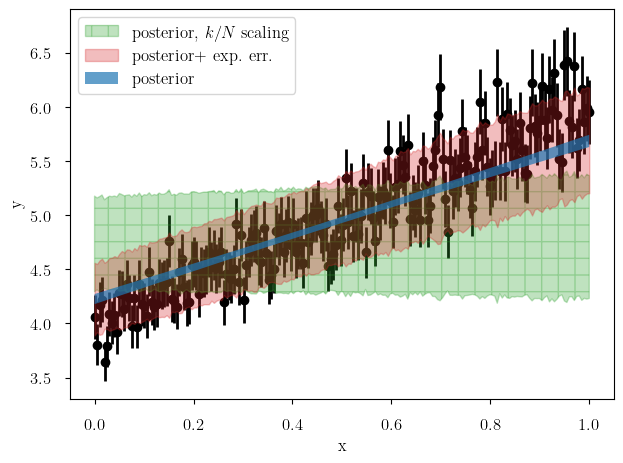

In [53]:
# plt.fill_between(x_data, lower_bounds[-2,:], upper_bounds[-2,:], alpha=0.5)
plt.errorbar(
    x_data, y_data, reported_stat_err, linestyle="none", marker="o", color="k", zorder=0
)
plt.fill_between(x_data, lower_s[-1, :], upper_s[-1, :], alpha=0.3, color="tab:green", label="posterior, $k/N$ scaling", hatch="|-")

plt.fill_between(x_data, lower[-1, :], upper[-1, :], alpha=0.3, color="tab:red", label="posterior+ exp. err.")
plt.fill_between(x_data, lower_l[-1, :], upper_l[-1, :], alpha=0.7, label="posterior")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.savefig(f"ci_scaled_vs_non_badprior.pdf")

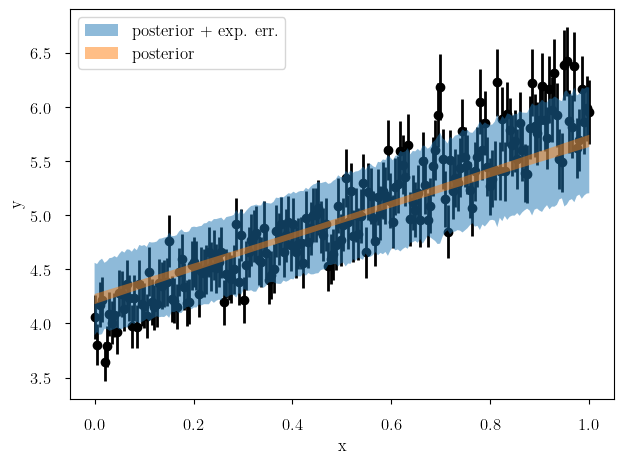

In [54]:
# plt.fill_between(x_data, lower_bounds[-2,:], upper_bounds[-2,:], alpha=0.5)
plt.errorbar(
    x_data, y_data, reported_stat_err, linestyle="none", marker="o", color="k", zorder=0
)
plt.fill_between(x_data, lower[-1, :], upper[-1, :], alpha=0.5,  label="posterior + exp. err.")
plt.fill_between(x_data, lower_l[-1, :], upper_l[-1, :], alpha=0.5, label="posterior")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.savefig(f"n{N}_ci.pdf")

In [38]:
def coverage_counted(y, err, lower, upper):
    coverage_integrated = np.zeros(len(lower))
    for i, (l, u) in enumerate(zip(lower, upper)):
        coverage_integrated[i] = np.mean(np.logical_and(y >= l, y < u))
    return coverage_integrated

In [39]:
def coverage(y, err, lower, upper):
    coverage_integrated = np.zeros(len(lower))
    for i, (l, u) in enumerate(zip(lower, upper)):
        coverage_integrated[i] = np.mean(
            norm.cdf((u - y) / err) - norm.cdf((l - y) / err)
        )
    return coverage_integrated

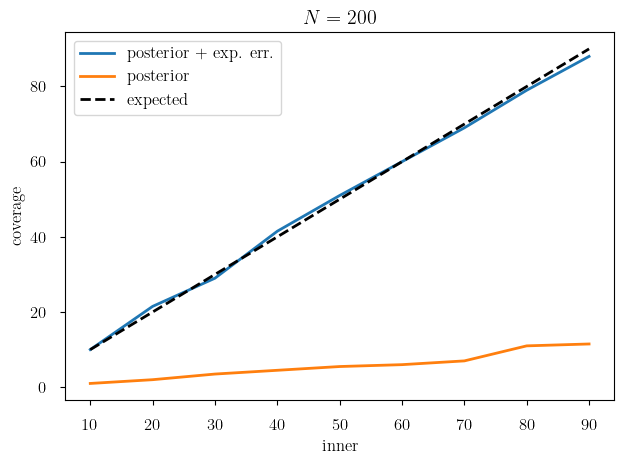

In [40]:
# plt.plot(inner_pctls, coverage_sum * 100, label="sum")

# cov = coverage_counted(y_data, reported_stat_err, lower_bounds, upper_bounds)
cov = coverage_counted(y_data, reported_stat_err, lower, upper)

plt.plot(
    inner_pctls,
    cov * 100,
    label="posterior + exp. err.",
)

cov = coverage_counted(y_data, reported_stat_err, lower_l, upper_l)
# cov = coverage_counted(y_data, reported_stat_err, lower_bounds, upper_bounds)

plt.plot(
    inner_pctls,
    cov * 100,
    label="posterior",
)

plt.plot(inner_pctls, inner_pctls, "k--", label="expected")
plt.legend()
plt.xlabel("inner %")
plt.ylabel("coverage %")
plt.title(f"$N = {N}$")
plt.tight_layout()
plt.savefig(f"n{N}_ec.pdf")